In [1]:
# set cuda visible devices
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

import os
if is_notebook():
    os.environ["CUDA_VISIBLE_DEVICES"] = "2" #"1"
    # os.environ['CUDA_LAUNCH_BLOCKING']="1"
    # os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
import torch 
torch.cuda.is_available()

True

# Hypothesis Testing Automatically Discovered Circuits

Procedure: 
- Compute prune scores (via attribution patching) 
- Search over different thresholds to find the smallest circuit where the null hypotheis of Equivalence / Dominance cannot be rejected 
- Prune edges from circuit that are not in paths to the output, or in the case of resample ablation cannot be reached from the input
- Test whether each edge in the circuit is minimal 
- Test whether the circuit is complete (by seeing if the null hypothesis on the independence test can be rejected)



In [3]:
import os
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import torch
import torch as t
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
from tqdm import tqdm

from omegaconf import OmegaConf


from auto_circuit.data import PromptPairBatch, PromptDataLoader
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.types import (BatchKey, PruneScores, CircuitOutputs, AblationType, 
                                Edge, BatchOutputs, EdgeCounts)
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.prune_algos.activation_patching import act_patch_prune_scores
from auto_circuit.prune_algos.ACDC import acdc_prune_scores
from auto_circuit.prune_algos.subnetwork_probing import subnetwork_probing_prune_scores
from auto_circuit.prune_algos.circuit_probing import circuit_probing_prune_scores
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.custom_tqdm import tqdm
from auto_circuit.utils.tensor_ops import desc_prune_scores
from auto_circuit.utils.graph_utils import edge_counts_util

from auto_circuit_tests.prune_algos import PruneAlgo
from auto_circuit_tests.score_funcs import GradFunc, AnswerFunc, DIV_ANSWER_FUNCS
# from auto_circuit_tests.faithful_metrics import FaithfulMetric

from auto_circuit_tests.utils.auto_circuit_utils import (
    run_circuit_with_edges_ablated, 
    run_fully_ablated_model, 
    flat_prune_scores_ordered
)

from auto_circuit_tests.faith_metrics import compute_faith_metrics
from auto_circuit_tests.hypo_tests.equiv_test import equiv_tests
from auto_circuit_tests.hypo_tests.minimality_test import (
    run_circuits_inflated_ablated, 
    score_diffs,
    minimality_test_edge,
    minimality_test, 
)
from auto_circuit_tests.hypo_tests.indep_test import independence_tests, indep_test
from auto_circuit_tests.hypo_tests.utils import (
    join_values, 
    remove_el,
    edges_from_mask, 
    result_to_json, 
)
from auto_circuit_tests.edge_graph import (
    SeqGraph,  
    sample_paths, 
    SampleType,
    edge_in_path, 
    find_unused_edges,
    visualize_graph
)

from auto_circuit_tests.tasks import TASK_DICT, TASK_TO_OUTPUT_ANSWER_FUNCS
from auto_circuit_tests.utils.auto_circuit_utils import edge_name
from auto_circuit_tests.utils.utils import (
    repo_path_to_abs_path, 
    load_cache, 
    save_cache, 
    save_json, 
    load_json, # should probably move this to auto_circuit_tests.utils
    get_el_rank
)
from auto_circuit_tests.utils.utils import get_exp_dir


/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# so I think the mechanistic explanation for ACDC doing better is probably 
    # self-repair mechanisms are more prominant when ablating edges from the full model, but the 
    # self-repair stuff is discarded by ACDC (and thresholding by prune score), so you do need certain edges
    # with no ablation score, and so activation pathcing has to search "farther out" for these important edges

In [66]:
# config class
from dataclasses import dataclass, field
@dataclass 
class Config: 
    task: str = "Indirect Object Identification Token Circuit" # check how many edges in component circuit (probably do all but ioi toen)
    ablation_type: AblationType = AblationType.RESAMPLE
    grad_func: GradFunc = GradFunc.LOGPROB
    answer_func: AnswerFunc = AnswerFunc.KL_DIV
    eval_grad_func: Optional[GradFunc] = None # TODO: used to evaluate faithfulness
    prune_algo: PruneAlgo = PruneAlgo.CIRC_PROBE
    eval_answer_func: Optional[AnswerFunc] = None
    ig_samples: Optional[int] = None
    layerwise: bool = False
    edge_counts: EdgeCounts = EdgeCounts.LOGARITHMIC
    tao_bases: list[float] = field(default_factory=lambda: [1, 5])
    tao_exps: list[float] = field(default_factory=lambda: list(range(-5, -1)))
    prune_score_thresh: bool = False
    alpha: float = 0.05
    epsilon: Optional[float] = 0.1
    q_star: float = 0.9 
    n_paths: int = 200
    sample_type: SampleType = SampleType.RANDOM_WALK
    # TODO: remove these?
    min_equiv_all_edges_thresh = 1000
    max_edges_to_test_in_order: int = 0 #TODO: change to 125
    max_edges_to_test_without_fail: int = 500 #TODO: change to 125
    save_cache: bool = True
    
    def __post_init__(self):
        # always override clean_corrupt for now
        self.clean_corrupt = "corrupt" if self.ablation_type == AblationType.RESAMPLE else None

        # set eval_grad_func and faith_answer_func to logit and max diff if answer_func is div
        if self.answer_func in DIV_ANSWER_FUNCS: 
            if self.eval_grad_func is None:
                self.eval_grad_func = GradFunc.LOGIT
            if self.eval_answer_func is None:
                self.eval_answer_func = AnswerFunc.MAX_DIFF

In [67]:
# initialize config 
conf = Config()
#get config overrides if runnign from command line
if not is_notebook():
    import sys 
    conf_dict = OmegaConf.merge(OmegaConf.structured(conf), OmegaConf.from_cli(sys.argv[1:]))
    conf = Config(**conf_dict)

In [68]:
# handle directories
task_dir, ablation_dir, out_answer_dir, ps_dir, edge_dir, exp_dir = get_exp_dir(
    task_key=conf.task, 
    ablation_type=conf.ablation_type,
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    prune_algo=conf.prune_algo,
    ig_samples=conf.ig_samples,
    layerwise=conf.layerwise,
    alpha=conf.alpha,
    epsilon=conf.epsilon,
    q_star=conf.q_star,
    prune_score_thresh=conf.prune_score_thresh,
)
exp_dir.mkdir(parents=True, exist_ok=True)

In [69]:
# initialize task
task = TASK_DICT[conf.task]
task.shuffle = False
task.init_task()

/nas/ucb/oliveradk/miniforge3/envs/auto-circuit-tests/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Loaded pretrained model gpt2-small into HookedTransformer
seq_len before divergence 15
seq_len after divergence 13


# Prune Scores

## ACDC Prune Scores

In [70]:
if conf.prune_algo == PruneAlgo.ACDC:
    auto_ps_path = out_answer_dir / "auto_prune_scores.pkl"
    if auto_ps_path.exists():
        auto_prune_scores = torch.load(auto_ps_path)
    else:
        if conf.task == "Indirect Object Identification Token Circuit":
            print("cannot run ACDC on IOI token circuit, too large")
            exit()
        auto_prune_scores = acdc_prune_scores(
            model=task.model, 
            dataloader=task.train_loader, 
            official_edges=None,
            tao_exps=conf.tao_exps,
            tao_bases=conf.tao_bases,
            faithfulness_target=conf.answer_func.value, 
        )
        if conf.save_cache:
            torch.save(auto_prune_scores, auto_ps_path)
    taos = sorted([tao_base * 10**tao_exp for tao_base, tao_exp in product(conf.tao_bases, conf.tao_exps)])

## Circuit Probing Prune Scores

In [73]:
if conf.prune_algo == PruneAlgo.CIRC_PROBE and conf.answer_func == AnswerFunc.KL_DIV:
    circ_probe_ps_path = out_answer_dir / "circ_probe_prune_scores.pkl"
    if circ_probe_ps_path.exists():
        circ_probe_prune_scores = torch.load(circ_probe_ps_path)
    else:
        circ_probe_prune_scores = circuit_probing_prune_scores(
            model=task.model, 
            dataloader=task.train_loader, 
            official_edges=None,
            tree_optimisation=True,
            faithfulness_target=conf.answer_func.value, 
            circuit_sizes=edge_counts_util(task.model.edges, conf.edge_counts, all_edges=False),
            learning_rate=0.1,
            epochs=100, 
            regularize_lambda=0.1, 
            show_train_graph=True
        )
        if conf.save_cache:
            torch.save(circ_probe_prune_scores, circ_probe_ps_path)

Circuit Probing Size 8448:           | 0/1 [00:00<?, ?it/s]

Circuit Probing Size 8448: ██████████| 1/1 [02:54<00:00, 174.34s/it]


## Activation Patching Prune Scores

In [ ]:
# load from cache if exists 
act_ps_path = out_answer_dir / "act_patch_prune_scores.pt"
if act_ps_path.exists():
    act_prune_scores = torch.load(act_ps_path)
    act_prune_scores = {mod_name: score for mod_name, score in act_prune_scores.items()} # negative b/c high score should imply large drop in performance
else:
    act_prune_scores = None

# if act_patch and act_patch doesn't exist, exit
if conf.prune_algo == PruneAlgo.ACT_PATCH and act_prune_scores is None:
    print("act_patch_prune_scores.pkl not found, exiting")
    exit()

##  Attribution Patching Prune Scores

In [12]:
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    attr_ps_name = "attrib_patch_prune_scores"
    attr_ps_path = (ps_dir / attr_ps_name).with_suffix(".pt")
    if (attr_ps_path).exists():
        attr_prune_scores = torch.load(attr_ps_path)
    else: 
        max_layer = max([edge.src.layer for edge in task.model.edges])

        attr_prune_scores = mask_gradient_prune_scores(
            model=task.model, 
            dataloader=task.train_loader,
            official_edges=None,
            grad_function=conf.grad_func.value, 
            answer_function=conf.answer_func.value, #answer_func,
            mask_val=0.0 if conf.ig_samples is None else None, 
            ablation_type=conf.ablation_type,
            integrated_grad_samples=conf.ig_samples, 
            layers=max_layer if conf.layerwise else None,
            clean_corrupt=conf.clean_corrupt,
        )
        if conf.save_cache:
            torch.save(attr_prune_scores, attr_ps_path)

##  Compare Activation and Attribution Patching

In [13]:
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    # order = sorted(list(act_prune_scores.keys()), key=lambda x: int(x.split('.')[1]))
    order = list(act_prune_scores.keys())
    act_prune_scores_flat = flat_prune_scores_ordered(act_prune_scores, order=order)
    attr_prune_scores_flat = flat_prune_scores_ordered(attr_prune_scores, order=order)

### MSE

In [14]:
# mse and median se
if conf.prune_algo != PruneAlgo.ACT_PATCH and act_prune_scores is not None:
    mse_result_name = "act_attr_mse"
    mse_result_path = (ps_dir / mse_result_name).with_suffix(".json")
    if mse_result_path.exists():
        mse_result = load_json(ps_dir, mse_result_name + '.json')
    else:
        prune_score_diffs = [
            (act_prune_scores[mod_name] - attr_prune_scores[mod_name]).flatten()
            for mod_name, _patch_mask in task.model.patch_masks.items()
        ]
        sq_error = torch.concat(prune_score_diffs).pow(2)
        median_se = sq_error.median()
        mean_se = sq_error.mean()
        mse_result = {
            "median_se": median_se.item(),
            "mean_se": mean_se.item(),
        }
        save_json(mse_result, ps_dir, mse_result_name)
    print(mse_result)

### Spearman Rank Correlation

In [15]:
if conf.prune_algo != PruneAlgo.ACT_PATCH and act_prune_scores is not None:
    from scipy import stats 
    abs_corr, abs_p_value = stats.spearmanr(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu())
    corr, p_value = stats.spearmanr(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu())
    print(f"abs corr: {abs_corr}, abs p-value: {abs_p_value}")
    print(f"corr: {corr}, p-value: {p_value}")

    spearman_results = {
        "abs_corr": abs_corr,
        "abs_p_value": abs_p_value,
        "corr": corr,
        "p_value": p_value,
    }
    save_json(spearman_results, ps_dir, "spearman_results")

### Plot Rank 

In [16]:
# get rank for scores
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    act_prune_scores_rank = get_el_rank(act_prune_scores_flat.cpu())
    attr_prune_scores_rank = get_el_rank(attr_prune_scores_flat.cpu())

    act_prune_scores_0 = (act_prune_scores_flat == 0).cpu()
    act_prune_scores_0_rank = act_prune_scores_rank[act_prune_scores_0]
    min_0_rank, max_0_rank = act_prune_scores_0_rank.min().item(), act_prune_scores_0_rank.max().item()

In [17]:
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    # TODO: plot x=0
    plt.scatter(act_prune_scores_rank, attr_prune_scores_rank, s=0.1)
    # plot min rank, max rank as vertical lines
    plt.axvline(min_0_rank, color='blue', linestyle='--')
    plt.axvline(max_0_rank, color='blue', linestyle='--')
    # shade area between min and max rank
    plt.axvspan(min_0_rank, max_0_rank, color='lightblue', alpha=0.5)
    
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation")

    plt.savefig(ps_dir / "rank_corr.png")

In [18]:
# TODO: I think there must be a bug? 
# get rank for scores
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    act_prune_scores_abs_rank = get_el_rank(act_prune_scores_flat.abs().cpu())
    attr_prune_scores_abs_rank = get_el_rank(attr_prune_scores_flat.abs().cpu())

    max_0_rank = act_prune_scores_abs_rank[act_prune_scores_0].max().item()

    plt.scatter(act_prune_scores_abs_rank, attr_prune_scores_abs_rank, s=0.1)
    # plot max rank as vertical lines
    plt.axvline(max_0_rank, color='blue', linestyle='--')
    # shade area between min and max rank
    plt.axvspan(0, max_0_rank, color='lightblue', alpha=0.5)

    
    plt.xlabel("Act Patch Rank")
    plt.ylabel("Attrib Patch Rank")
    plt.title("Rank Correlation Abs")
    plt.savefig(ps_dir / "rank_corr_abs.png")

### Compute Fraction of "Mis-Signed" Components

In [19]:
if conf.prune_algo != PruneAlgo.ACT_PATCH and act_prune_scores is not None:
    num_missigned = (act_prune_scores_flat.sign() != attr_prune_scores_flat.sign()).sum()
    frac_missigned = num_missigned / len(act_prune_scores_flat)
    print(f"Fraction of missigned: {frac_missigned}")
    save_json({"frac_missigned": frac_missigned.item()}, ps_dir, "missigned")

### Compute Fraction of Edges Recovered for Each Edge Threshold

In [20]:
# for different edge thresholds, compute fraction of edges not included in top k
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    edge_counts = edge_counts_util(task.model.edges, conf.edge_counts, zero_edges=True)

    frac_edges_recovered: Dict[int, float] = {}

    for edge_count in edge_counts:
        # get indicies where act_prune_scores_abs_rank >= task.n_edges - edge_count
        act_indices = act_prune_scores_abs_rank >= task.model.n_edges - edge_count
        frac_edges_recovered[edge_count] = (attr_prune_scores_abs_rank[act_indices] >= task.model.n_edges - edge_count).to(t.float).mean().item()

    save_json(frac_edges_recovered, ps_dir, "frac_edges_recovered")

### Parition by Dest Component

We partion by Dest B/c we expect difficulties to arise from estimating effects that route through non-linearities

In [21]:
from auto_circuit_tests.edge_graph import NodeType

def mod_name_to_layer_and_node_type(mod_name: str) -> Tuple[int, NodeType]:
    _blocks, layer, node_type_str = mod_name.split('.')
    layer = int(layer)
    if node_type_str == "hook_k_input":
        node_type = NodeType.K 
    elif node_type_str == "hook_q_input":
        node_type = NodeType.Q
    elif node_type_str == "hook_v_input":
        node_type = NodeType.V
    elif node_type_str == "hook_resid_post":
        node_type = NodeType.RESID_END 
    elif node_type_str == "hook_mlp_in":
        node_type = NodeType.MLP
    else: 
        raise ValueError(f"Unknown node type: {node_type_str}")
    return layer, node_type

In [22]:
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    from auto_circuit_tests.edge_graph import NodeType
    # compute ranking by flatten by order, including module name 
    def prune_score_rankings_by_component(
        prune_scores: PruneScores, 
        prune_scores_rank: torch.Tensor, 
        order: list[str]
    ) -> dict[tuple[int, NodeType], list[int]]:
        # collect mod_name ranking tuples
        flat_mod_names = [] 
        for mod_name in order:
            flat_mod_names.extend([mod_name for _ in range(prune_scores[mod_name].numel())])
        # get ranking by component type and layer
        rank_by_component: dict[tuple[int, NodeType], list[int]] = defaultdict(list)
        for mod_name, rank in zip(flat_mod_names, prune_scores_rank):
            layer, node_type = mod_name_to_layer_and_node_type(mod_name)
            rank_by_component[(layer, node_type)].append(rank)
        return rank_by_component

    act_rank_by_component = prune_score_rankings_by_component(act_prune_scores, act_prune_scores_abs_rank, order)
    attr_rank_by_component = prune_score_rankings_by_component(attr_prune_scores, attr_prune_scores_abs_rank, order)

In [23]:
if conf.prune_algo != PruneAlgo.ACT_PATCH:
    import matplotlib.pyplot as plt
    import numpy as np

    # plot ranks for each component type all in one figure
    n_layers = max([layer for layer, _ in act_rank_by_component.keys()])
    components = sorted(list(set([node_type for _, node_type in act_rank_by_component.keys()])), key=lambda x: x.value)

    # Create a 2D array to store the Axes objects
    axs = np.empty((len(components), n_layers + 1), dtype=object)

    # Create the figure without subplots initially
    fig = plt.figure(figsize=(3 * (n_layers+1), 3 * len(components)))


    rank_correlations: dict[tuple[int, NodeType], float] = {}
    for layer in range(0, n_layers + 1):
        for i, node_type in enumerate(components):
            act_ranks = act_rank_by_component[(layer, node_type)]
            attr_ranks = attr_rank_by_component[(layer, node_type)]
            
            if len(act_ranks) == 0 and len(attr_ranks) == 0:
                continue

            # compute rank correlation
            corr, p_value = stats.spearmanr(act_ranks, attr_ranks)
            rank_correlations[(layer, node_type)] = corr
            
            # Create a subplot only if there's data to plot
            ax = fig.add_subplot(len(components), (n_layers+1), (i * (n_layers+1)) + layer+1)
            ax.scatter(act_ranks, attr_ranks, s=1)
            # set title below scatter plot
            ax.set_title(f"Correlation: {corr:.2f}", y=-0.20)

            
            # Store the Axes object in our 2D array
            axs[i, layer - 1] = ax

            # Add x-label at the top
            if i == 0:
                ax.xaxis.set_label_position('top')
                ax.set_xlabel(f"Layer {layer}", fontweight='bold')
            
            # Add y-label on the left
            if layer == 0 or node_type == NodeType.RESID_END:
                ax.set_ylabel(str(node_type.name), fontweight='bold')

    # Remove empty spaces in the figure
    fig.tight_layout()
    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # save figure

    plt.savefig(ps_dir / "rank_corr_by_component.png")


    # save rank correlations
    save_json({str(k): v for k, v in rank_correlations.items()}, ps_dir, "rank_cor_by_component")

### Plot Scores

In [24]:
if conf.prune_algo != PruneAlgo.ACT_PATCH and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.cpu(), attr_prune_scores_flat.cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("symlog")
    plt.yscale("symlog")
    plt.savefig(ps_dir / "act_attr_scores.png")

In [25]:
if conf.prune_algo != PruneAlgo.ACT_PATCH and act_prune_scores is not None:
    # plot scores on x, y
    plt.scatter(act_prune_scores_flat.abs().cpu(), attr_prune_scores_flat.abs().cpu(), alpha=0.25)
    plt.xlabel("Act Patch Scores")
    plt.ylabel("Attrib Patch Scores")
    plt.xscale("log")
    plt.yscale("log")
    plt.savefig(ps_dir / "act_attr_abs_scores.png")


# Construt Circuits from Prune Scores 

Constructing circuits from prune scores using either edge or fraction of prune score thresholds

In [31]:
# set prune scores
if conf.prune_algo == PruneAlgo.ACDC:
    prune_scores = auto_prune_scores
elif conf.prune_algo == PruneAlgo.CIRC_PROBE:
    prune_scores = circ_probe_prune_scores
elif conf.prune_algo == PruneAlgo.ACT_PATCH:
    prune_scores = act_prune_scores
else:
    prune_scores = attr_prune_scores
# sort prune scores
sorted_prune_scores = desc_prune_scores(prune_scores)

In [ ]:
# plot prune scores
def plot_prune_scores(edge_scores):
    fig, ax = plt.subplots()
    # plot edge scores with x labels max to 0 
    ax.plot(sorted(edge_scores, reverse=True))
    ax.set_xlim(len(edge_scores), 0)
    # log axis 
    ax.set_yscale('log')
    ax.set_xlabel("Edge Count")
    ax.set_ylabel("Edge Score")
    return fig, ax

fig, ax = plot_prune_scores(sorted_prune_scores.cpu().numpy().tolist())
plt.savefig(exp_dir / "edge_scores.png")

In [33]:
# compute n_edges 
from auto_circuit.utils.graph_utils import edge_counts_util
circ_edges = []
if conf.prune_algo == PruneAlgo.ACDC:
     circ_edges = [
         t.sum(t.cat([t.flatten(v) for v in auto_prune_scores.values()]) > tao).item()
        for tao in taos
    ]
     circ_thresholds = taos[1:] + [t.inf] # prune scores set to tau if change less than tau
else:
    circ_edges = edge_counts_util(task.model.edges, conf.edge_counts, zero_edges=True)
    circ_thresholds = [sorted_prune_scores[n_edges-1].item() for n_edges in circ_edges]

save_json(circ_edges, edge_dir, "n_circ_edges")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/edges/n_circ_edges.json


# Faithfulness: % Loss Recovered and Equivalence Test

Use equivalence test from Shi et al to test a. if not equivalent and b. if equivalent

We also compute: 
- mean absolute error: E[abs(score(M) - score(C))] 
(spiritually similar to Transfomer Circuits not Robust and this comment https://www.lesswrong.com/posts/kcZZAsEjwrbczxN2i/causal-scrubbing-appendix#hJoCMcgXpk8jBLvb7, we don't do fraction of recovered b/c the negatives are weird and annoying)
- mean difference: E[score(M)] - E[score(C)] 
(kind of a middle ground, measuring bias)
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)] 
(SAE work, similar to causal scrubbing, don't need to worry about variance)

In [35]:
# first full model outt and ablated model out

with t.inference_mode():
    model_out_train: BatchOutputs = {
        batch.key: task.model(batch.clean)[task.model.out_slice] 
        for batch in task.train_loader
    }
    model_out_test: BatchOutputs = {
        batch.key: task.model(batch.clean)[task.model.out_slice] 
        for batch in task.test_loader
    }

ablated_out_train: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.train_loader,
    ablation_type=conf.ablation_type,
)

ablated_out_test: BatchOutputs = run_fully_ablated_model(
    model=task.model,
    dataloader=task.test_loader,
    ablation_type=conf.ablation_type,
)

Pruning Batch 1██████████| 2/2 [00:00<00:00, 12.52it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00, 11.85it/s]


In [36]:
# next get circuit outs for each threshold
from auto_circuit.prune import run_circuits
from auto_circuit.types import CircuitOutputs, PatchType
circuit_outs_train: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)

circuit_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.TREE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=False, 
)

Pruning Batch 1██████████| 2/2 [00:00<00:00,  8.32it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00,  7.40it/s]


## Faithfulness Metrics

- mae: E[abs(score(M) - score(C))] 
- mean difference: E[score(M)] - E[score(C)] 
- frac mean difference recovered: E[score(C)] - E[score(A)] / E[score(M)] - E[score(A)]

In [37]:
faith_metric_results_train, faith_metrics_train = compute_faith_metrics(
    task.train_loader,
    model_out_train,
    ablated_out_train,
    circuit_outs_train,
    conf.grad_func,
    conf.answer_func,
)

faith_metric_results_test, faith_metrics_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    circuit_outs_test,
    conf.grad_func,
    conf.answer_func,
)

save_json(faith_metric_results_train, ps_dir, "faith_metric_results_train")
save_json(faith_metrics_train, ps_dir, "faith_metrics_train")
save_json(faith_metric_results_test, ps_dir, "faith_metric_results_test")
save_json(faith_metrics_test, ps_dir, "faith_metrics_test")

██████████| 2/2 [00:00<00:00, 129.33it/s]
██████████| 2/2 [00:00<00:00, 145.64it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_test.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_test.json


In [38]:
# faith metrics eval 
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    faith_metric_results_train_eval, faith_metrics_train_eval = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        circuit_outs_train,
        conf.eval_grad_func,
        conf.eval_answer_func,
    )

    faith_metric_results_test_eval, faith_metrics_test_eval = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        circuit_outs_test,
        conf.eval_grad_func,
        conf.eval_answer_func,
    )
    save_json(faith_metric_results_train_eval, ps_dir, "faith_metric_results_train_eval")
    save_json(faith_metrics_train_eval, ps_dir, "faith_metrics_train_eval")
    save_json(faith_metric_results_test_eval, ps_dir, "faith_metric_results_test_eval")
    save_json(faith_metrics_test_eval, ps_dir, "faith_metrics_test_eval")

██████████| 2/2 [00:00<00:00, 164.36it/s]
██████████| 2/2 [00:00<00:00, 243.91it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_test_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_test_eval.json


## Equivalence Tests

In [39]:
use_eval_metrics = conf.answer_func in DIV_ANSWER_FUNCS
equiv_test_results_train = equiv_tests(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    grad_func=conf.grad_func if not use_eval_metrics else conf.eval_grad_func,
    answer_func=conf.answer_func if not use_eval_metrics else conf.eval_answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    circuit_outs=circuit_outs_train,
    null_equiv=False, 
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

equiv_test_results_test = equiv_tests(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    grad_func=conf.grad_func if not use_eval_metrics else conf.eval_grad_func,
    answer_func=conf.answer_func if not use_eval_metrics else conf.eval_answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    circuit_outs=circuit_outs_test,
    null_equiv=False, 
    alpha=conf.alpha,
    epsilon=conf.epsilon,
)

save_json(equiv_test_results_train, ps_dir, "equiv_test_results_train")
save_json(equiv_test_results_test, ps_dir, "equiv_test_results_test")

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/equiv_test_results_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/equiv_test_results_test.json


## TODO: Sufficiency Test, and Expected Loss Recovered with Respect to Expected Value of Random Circuit of the same size

## Plot % loss recovered and Equiv Test Results Along Frac Edges / Frac Prune Scores

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from fractions import Fraction

def plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results: Dict[int, Dict[str, float]], 
    equiv_test_results: Optional[Dict[int, NamedTuple]]=None,
    title: str = "", 
    null_good: bool = True,
    x_label: str = "Edges"
):
    n_edges = list(faith_metric_results.keys())
    fracs = [n_edge / task.model.n_edges for n_edge in n_edges]
    frac_loss_recovered = [faith_metric_results[n_edge]["frac_mean_diff_recovered"] for n_edge in n_edges]
    

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot line
    ax.plot(fracs, frac_loss_recovered, color='blue')

    null_reject_color = 'blue' if null_good else 'green'
    null_not_reject_color = 'green' if null_good else 'blue'
    
    # Plot dots, with color based on null hypothesis rejection
    if equiv_test_results is not None:
        reject_null = [result.reject_null for result in equiv_test_results.values()]
        for frac, loss, reject in zip(fracs, frac_loss_recovered, reject_null):
            color = null_reject_color if reject else null_not_reject_color
            ax.scatter(frac, loss, color=color, s=100, zorder=5)  # s is the size of the dot, zorder ensures it's on top

    ax.set_xlabel(f"Fraction of Total {x_label}")
    ax.set_ylabel("Fraction of Loss Recovered")
    ax.set_title(title)

    # horizontal line at 0.95
    ax.axhline(0.95, color='r', linestyle='--')

    # Set x-axis ticks and labels
    x_ticks = np.arange(0, 1.0, 0.1)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([f'{x:.1f}' for x in x_ticks])

    # Set x-axis limits
    ax.set_xlim(0, 1.0)

    # Add legend
    if equiv_test_results is not None:
        ax.scatter([], [], color=null_reject_color, label='Null Rejected', s=100)
        ax.scatter([], [], color=null_not_reject_color, label='Null Not Rejected', s=100)
        ax.legend()

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    return fig, ax

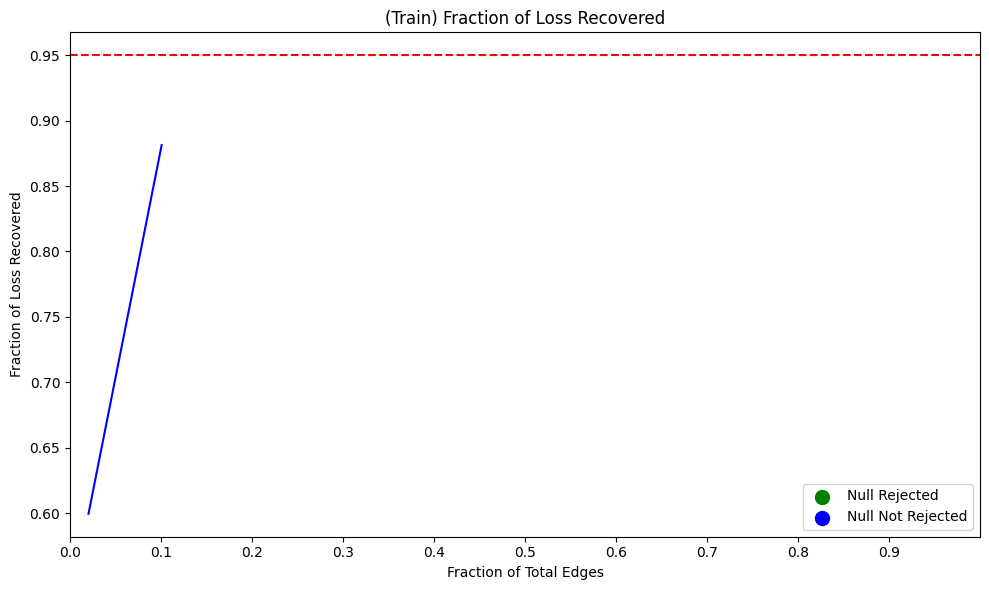

In [44]:
# plot results using div answer function (no equivalence results)
if use_eval_metrics:
    # TODO: figure out why this plotting is off
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_train,
        title="(Train) Fraction of Loss Recovered",
        null_good=False,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_results_train.png")

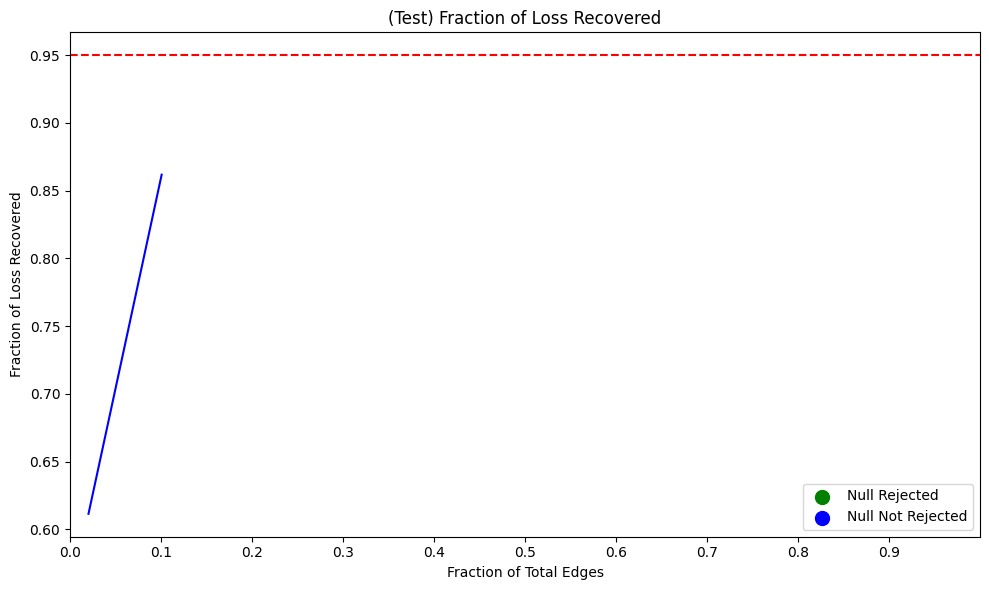

In [47]:
# plot results using div answer function (no equivalence results)
if use_eval_metrics:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_test,
        title="(Test) Fraction of Loss Recovered",
        null_good=False,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_results_test.png")

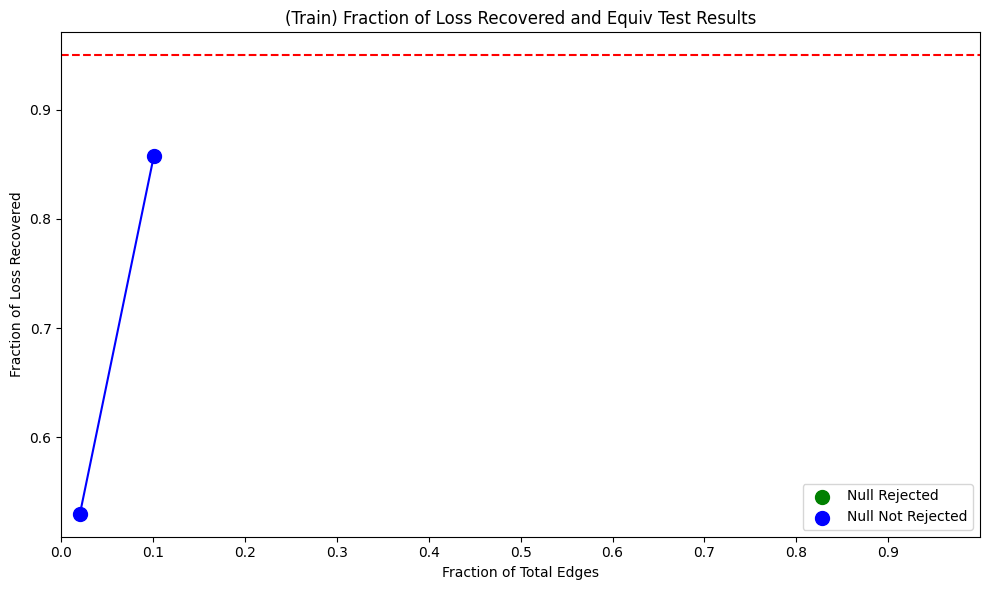

In [46]:
# TODO: figure out why this plotting is off

fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_train if not use_eval_metrics else faith_metric_results_train_eval, 
    equiv_test_results_train,
    title="(Train) Fraction of Loss Recovered and Equiv Test Results",
    null_good=False,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_train.png")


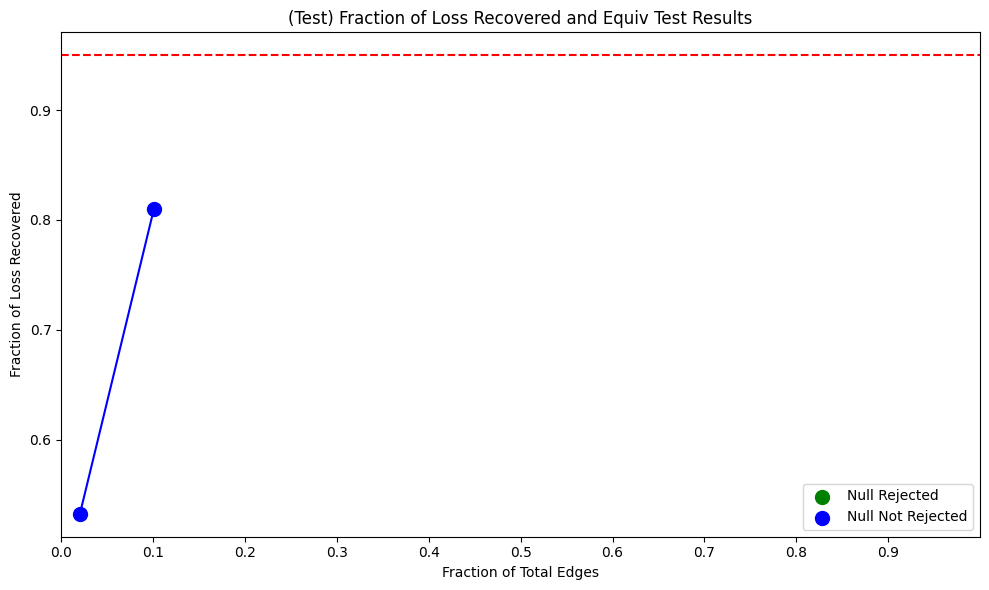

In [42]:
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_test if not use_eval_metrics else faith_metric_results_test_eval, 
    equiv_test_results_test,
    title="(Test) Fraction of Loss Recovered and Equiv Test Results",
    null_good=False,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_equiv_test_results_test.png")

# Minimality of Smallest Circuit with %loss recovered > 0.95

## Find Smallest Equivalent Circuit

In [37]:
flat_ps = flat_prune_scores_ordered(prune_scores, order=prune_scores.keys())

In [ ]:
# find smallest equiv circuit on training distribution
edge_counts_equiv_idx = [
    i for i, (k, v) in enumerate(equiv_test_results_train.items())
    if faith_metric_results_train[k]['frac_mean_diff_recovered'] > 0.95 
    #and v.reject_null 
]
n_edges_min_equi_idx = min(edge_counts_equiv_idx) if edge_counts_equiv_idx else -1
n_edges_min_equiv = circ_edges[n_edges_min_equi_idx]
threshold = circ_thresholds[n_edges_min_equi_idx]

# get edges of circuit
edge_mask = {k: torch.abs(v) >= threshold for k, v in prune_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, task.token_circuit)
save_json([(edge.seq_idx, edge.name) for edge in  edges], edge_dir, "min_equiv_edges_train")

In [82]:
valid_task = TASK_TO_OUTPUT_ANSWER_FUNCS[conf.task] == (conf.grad_func, conf.answer_func) or conf.answer_func in DIV_ANSWER_FUNCS
test_smallest = valid_task and len(edges) < 20_000

## Plot Pruned Smallest Equivalent Circuit

In [40]:
if test_smallest:
    fig = draw_seq_graph(
        model=task.model,
        prune_scores=prune_scores,
        score_threshold=threshold,
        show_all_seq_pos=True,
        orientation="h",
        display_ipython=False,#is_notebook(),
        seq_labels=task.test_loader.seq_labels,
    )
    fig.write_image(repo_path_to_abs_path(edge_dir / "smallest_equiv_circ_graph_train.png"))

## Find Unused Edges

Note: Seems like there is some leakage, not exactly sure why, but I guess its fine, not using this anyway

In [41]:
if test_smallest:
    # from auto_circuit_tests.edge_graph import find_unused_edges
    def sum_prune_scores(edges: list[Edge]) -> t.Tensor:
        return sum([
            torch.abs(prune_scores[edge.dest.module_name][edge.patch_idx])
            for edge in edges
        ])
    # find unused edges
    used_edges, unused_edges, _circ_graph = find_unused_edges(
        edges, conf.ablation_type, token_circuit=task.token_circuit, attn_only=task.model.cfg.attn_only
        )
    # get prune scores for each unused edge 
    unused_edge_prune_scores_train = {
        edge: prune_scores[edge.dest.module_name][edge.patch_idx]
        for edge in unused_edges
    }
    # save unused edges with prune scores
    # save_json(unused_edge_prune_scores_train, edge_dir, "unused_edges_train")
    print(f"Fraction of unused edges: {len(unused_edges) / len(edges)}")
    save_json(len(unused_edges) / len(edges), edge_dir, "frac_unused_edges")
    # save fraction of prune scores attributed to unused edges in circuit
    total_circuit_prune_scores = sum_prune_scores(edges)
    unused_edge_prune_scores_abs = sum_prune_scores(unused_edges)
    save_json((unused_edge_prune_scores_abs / total_circuit_prune_scores).item(), edge_dir, "frac_unused_edge_scores")

### Verify Pruned Smallest Circuit Still Equivalent and achieves >95% loss recovered

In [42]:
if test_smallest:
    from auto_circuit.types import PruneScores
    # get prune score mask
    def edges_to_prune_score_mask(edges: list[Edge]) -> t.Tensor:
        mask = task.model.new_prune_scores()
        for edge in edges:
            mask[edge.dest.module_name][edge.patch_idx] = 1
        return mask

    # compute circuit outputs for used edges 
    def run_circuit_from_mask(
        mask: PruneScores, 
        dataloader: PromptDataLoader,
    ) -> CircuitOutputs:
        circuit_out: CircuitOutputs = run_circuits(
            model=task.model, 
            dataloader=dataloader,
            prune_scores=mask,
            thresholds = [0.5],
            patch_type=PatchType.TREE_PATCH, 
            ablation_type=conf.ablation_type,
            reverse_clean_corrupt=False, 
        )
        return circuit_out

    used_edges_mask = edges_to_prune_score_mask(used_edges)
    used_edges_out = run_circuit_from_mask(used_edges_mask, task.train_loader)

In [43]:
if test_smallest:
# compute faithfulness metrics 
    faith_metric_results_used_edges, faith_metrics_used_edges = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        used_edges_out,
        conf.grad_func,
        conf.answer_func,
    )
    print(f"Used Edges Train %loss recovered: {list(faith_metric_results_used_edges.values())[0]['frac_mean_diff_recovered']}")
    save_json(faith_metric_results_used_edges, ps_dir, "faith_metric_results_used_edges")

In [44]:
# run equiv tests on used edges
if test_smallest:
    equiv_test_results_used_edges = equiv_tests(
        model=task.model, 
        dataloader=task.train_loader,
        prune_scores=used_edges_mask,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_train,
        circuit_outs=used_edges_out,
        null_equiv=False, 
        alpha=conf.alpha,
        epsilon=conf.epsilon,
    )
    print(f"Used Edges Null Rejected: {list(equiv_test_results_used_edges.values())[0].reject_null}")
    save_json(equiv_test_results_used_edges, ps_dir, "equiv_test_results_used_edges")


## Minimality Test and Change in %loss Recovered

In [45]:
# only run on docstring to save time
run_min_test = test_smallest

### Run Circuits with Each Edge Ablated 

In [46]:
if run_min_test:
    edge_outs_train= run_circuit_with_edges_ablated(
        model=task.model,
        dataloader=task.train_loader,
        prune_scores=prune_scores,
        edges=edges,
        ablation_type=conf.ablation_type,
        threshold=threshold,
    )

    edge_outs_test = run_circuit_with_edges_ablated(
        model=task.model,
        dataloader=task.test_loader,
        prune_scores=prune_scores,
        edges=edges,
        ablation_type=conf.ablation_type,
        threshold=threshold,
    )

### Compute Change in %loss recovered

In [47]:
if run_min_test:
    edge_faith_metric_results_train, edge_faith_metrics_train = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        edge_outs_train, # NOTE - wrong data type, keys should be ints, but doesn't matter
        conf.grad_func,
        conf.answer_func,
    )
    # hmm this should just be by edge, also I want the edge order
    save_json({edge_name(k): v for k, v in edge_faith_metric_results_train.items()}, ps_dir, "edge_faith_metric_results_train")
    save_json({edge_name(k): v for k, v in edge_faith_metrics_train.items()}, ps_dir, "edge_faith_metrics_train")

    edge_faith_metric_results_test, edge_faith_metrics_test = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        edge_outs_test, # NOTE - wrong data type, keys should be ints, but doesn't matter
        conf.grad_func,
        conf.answer_func,
    )
    save_json({edge_name(k): v for k, v in edge_faith_metric_results_test.items()}, ps_dir, "edge_faith_metric_results_test")
    save_json({edge_name(k): v for k, v in edge_faith_metrics_test.items()}, ps_dir, "edge_faith_metrics_test")

In [48]:
if run_min_test:
    # plot change in loss recovered 
    frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv]['frac_mean_diff_recovered']
    frac_loss_recovered_test = faith_metric_results_test[n_edges_min_equiv]['frac_mean_diff_recovered']
    # sort edges by prune scores 
    edge_prune_scores = {
        edge: prune_scores[edge.dest.module_name][edge.patch_idx].cpu().item()
        for edge in edges
    }
    sorted_edge_prune_scores = sorted(edge_prune_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    frac_loss_recovered_train_sorted = [edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores]
    frac_loss_recovered_test_sorted = [edge_faith_metric_results_test[edge]['frac_mean_diff_recovered'] for edge, _ in sorted_edge_prune_scores]

    fig, ax = plt.subplots()
    # add transparency to lines
    ax.plot([frac_loss_recovered_train - x for x in reversed(frac_loss_recovered_train_sorted)], label="Train")
    ax.plot([frac_loss_recovered_test - x for x in reversed(frac_loss_recovered_test_sorted)], label="Test", alpha=0.75)
    # horizontal line at 1/circuit_size
    ax.axhline((1/ len(edges)) * 100, color='r', linestyle='--')

    ax.set_xlabel("Edge Index")
    ax.set_ylabel("Change in Fraction of Loss Recovered")
    ax.set_title("Change in Fraction of Loss Recovered for Each Edge")

    # add legend
    ax.legend()

### Minimality Test

In [49]:
if run_min_test:
    # build full grap to sample paths
    graph = SeqGraph(task.model.edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)

In [50]:
if run_min_test:
    # ok so there should be columns for each sequence position, and subcolumsn for each component
    seq_idxs = [0, task.test_loader.seq_len-1] if task.token_circuit else None
    visualize_graph(graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, column_width=5, figsize=(36, 24))

In [51]:
# plot circuit graph
if run_min_test:
    circ_graph = SeqGraph(edges, token=task.token_circuit, attn_only=task.model.cfg.attn_only)
    seq_idxs = set([seq_node.seq_idx for seq_node in circ_graph.seq_nodes])
    visualize_graph(circ_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, column_width=10, figsize=(72, 24))

In [52]:
# sample paths from complement for each data instance
if run_min_test:
    complement_edges = set(task.model.edges) - set(edges)
    sampled_paths = sample_paths(
        seq_graph=graph, 
        n_paths=conf.n_paths, 
        complement_edges=complement_edges,
    )
    edges_set = set(edges)
    novel_edge_paths = [[edge for edge in path if edge not in edges_set] for path in sampled_paths]

In [53]:
if run_min_test:
    path_idx = 0
    sampled_path = sampled_paths[path_idx]
    novel_edges = novel_edge_paths[path_idx]
    redundant_edges = set(sampled_path).intersection(set(edges))
    print(f"Added edges: {novel_edges}")
    print(f"Redundant edges: {redundant_edges}")
    ex_inflated_graph = SeqGraph(edges + list(novel_edges), token=task.token_circuit, attn_only=task.model.cfg.attn_only)
    seq_idxs = set([seq_node.seq_idx for seq_node in ex_inflated_graph.seq_nodes]) if task.token_circuit else None
    edge_colors = {}
    [edge_colors.update({edge: 'blue'}) for edge in novel_edges]
    [edge_colors.update({edge: 'darkblue'}) for edge in redundant_edges]
    visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, edge_colors=edge_colors)

In [54]:
# sample paths to remove 
if run_min_test:
    ablated_paths, removed_edges = [], []
    for path in novel_edge_paths:
        edge_idx_to_remove = random.choice(range(len(path)))
        ablated_path = remove_el(path, edge_idx_to_remove)
        ablated_paths.append(ablated_path)
        removed_edges.append(path[edge_idx_to_remove])
    removed_edge = removed_edges[path_idx]
    edge_colors[removed_edge] = 'red'
    visualize_graph(ex_inflated_graph, sort_by_head=False, max_layer=None, seq_idxs=seq_idxs, edge_colors=edge_colors)

In [55]:
if run_min_test:
    inflated_outs, ablated_outs = run_circuits_inflated_ablated(
        model=task.model, 
        dataloader=task.train_loader,
        ablation_type=conf.ablation_type,
        edges=edges,
        n_paths=conf.n_paths,
        graph=graph,
        paths=sampled_paths,
        ablated_paths=ablated_paths,
        token=task.token_circuit,
    )

In [56]:
if run_min_test:
    # compute mean diffs for each inflated circuit / ablated circuit
    inflated_ablated_mean_diffs: list[float] = []
    for i, inflated_out in inflated_outs.items():
        inflated_ablated_diffs = score_diffs(
            dataloader=task.train_loader,
            outs_1=inflated_out,
            outs_2=ablated_outs[i],
            grad_func=conf.grad_func,
            answer_func=conf.answer_func,
            device=task.device
        )
        inflated_ablated_mean_diffs.append(t.cat(inflated_ablated_diffs).mean().item())

    # compute mean diffs for each ablated edge
    ablated_edge_mean_diffs: dict[Edge, float] = {}
    for edge in edges:
        ablated_diffs = score_diffs(
            dataloader=task.train_loader,
            outs_1=edge_outs_train[edge],
            outs_2=circuit_outs_train[n_edges_min_equiv],
            grad_func=conf.grad_func,
            answer_func=conf.answer_func,
            model_outs=model_out_train,
            device=task.device
        )
        ablated_edge_mean_diffs[edge] = t.cat(ablated_diffs).mean().item()

In [57]:
if run_min_test:
    min_results_train = {}
    for edge in tqdm(edges):
        min_results_train[edge] = minimality_test_edge(
            ablated_edge_mean_diff=ablated_edge_mean_diffs[edge],
            inflated_ablated_mean_diffs=inflated_ablated_mean_diffs,
            null_minimal=False,
            alpha=conf.alpha / len(edges), # bonferroni correction
            q_star=conf.q_star,
        )

In [58]:
if run_min_test:
    # plot minimality scores and fraction of loss recovered sorted by minimality score with threshold for rejection (from paper)
    edges_by_min_score = sorted(edges, key=lambda edge: ablated_edge_mean_diffs[edge], reverse=False)
    min_scores = [ablated_edge_mean_diffs[edge] for edge in edges_by_min_score]
    frac_loss_recovered_train = faith_metric_results_train[n_edges_min_equiv]['frac_mean_diff_recovered']
    frac_loss_recovered_delta = [frac_loss_recovered_train - edge_faith_metric_results_train[edge]['frac_mean_diff_recovered'] for edge in edges_by_min_score]
    first_minimal_edge = [min_results_train[edge].reject_null for edge in edges_by_min_score].index(True)

    # plot minimality scores and fraction of loss recovered
    fig, ax = plt.subplots()
    ax.plot(min_scores, label="Change in Score")
    ax.set_xlabel("Edge Index")
    ax.set_ylabel("Change in Score")
    # ax.set_yscale('log')
    # new axis for fraction of loss recovered
    ax2 = ax.twinx()
    ax2.plot(frac_loss_recovered_delta, label="Change in Fraction of Loss Recovered", color='orange', alpha=0.75)
    ax2.set_ylabel("Change in Fraction of Loss Recovered")

    # add vertical line for first minimal edge
    ax.axvline(first_minimal_edge, color='blue', linestyle='--')
    # shade region left of first minimal edge
    ax.axvspan(0, first_minimal_edge, color='lightblue', alpha=0.5)
    # TODO: put fig legend where ax legend would be 
    fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.95))
    fig.tight_layout()

In [59]:
if run_min_test:
    # plot correlation between minimality score (change in score) and prune score 
    edge_prune_scores = [prune_scores[edge.dest.module_name][edge.patch_idx].item() for edge in edges_by_min_score]
    edge_prune_scores_rank = get_el_rank(t.tensor(edge_prune_scores))
    min_scores_rank = get_el_rank(t.tensor(min_scores))
    plt.scatter(edge_prune_scores_rank, min_scores_rank, s=1.0)
    plt.xlabel("Prune Score Rank")
    plt.ylabel("Circuit Prune Score Rank")
    plt.savefig(edge_dir / "min_score_corr.png")

    # plot minimality score sorted by prune scores 

In [60]:
if run_min_test:
    min_results_test, null_rejected_test = minimality_test(
        model=task.model, 
        dataloader=task.test_loader,
        edges=edges,
        prune_scores=prune_scores,
        threshold=threshold,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        token=task.token_circuit,
        model_outs=model_out_test,
        n_paths=conf.n_paths,
        null_minimal=False, 
        bonferonni=False, 
        q_star=conf.q_star,
        device=task.device,
    )

### Minimality Test on "Ground Truth" Circuit

In [61]:
if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func):
    # inflated ablated 
    inflated_outs_true, ablated_outs_true = run_circuits_inflated_ablated(
        model=task.model,
        dataloader=task.test_loader,
        ablation_type=conf.ablation_type,
        edges=edges,
        n_paths=conf.n_paths,
        token=task.token_circuit
    )

    # compute mean diffs for each inflated circuit / ablated circuit
    inflated_ablated_mean_diffs_true: list[float] = []
    for i, inflated_out in inflated_outs_true.items():
        inflated_ablated_diffs = score_diffs(
            dataloader=task.test_loader,
            outs_1=inflated_out,
            outs_2=ablated_outs_true[i],
            grad_func=conf.grad_func,
            answer_func=conf.answer_func,
            model_outs=model_out_test,
            device=task.device
        )
        inflated_ablated_mean_diffs_true.append(t.cat(inflated_ablated_diffs).mean().item())

In [62]:
if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func):
    true_edges_min_test_results, null_rejected = minimality_test(
        model=task.model, 
        dataloader=task.test_loader,
        edges=list(task.true_edges),
        prune_scores=task.model.circuit_prune_scores(task.true_edges),
        threshold=0.5,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        ablation_type=conf.ablation_type,
        token=task.token_circuit,
        inflated_outs=inflated_outs_true,
        ablated_outs=ablated_outs_true,
        # n_paths=conf.n_paths,
        null_minimal=True, 
        bonferonni=True, 
        q_star=conf.q_star,
        device=task.device,
        stop_if_reject=True
    )
    save_json({edge_name(k): v for k, v in true_edges_min_test_results.items()}, edge_dir, "true_edges_min_test_results")

# Independence Test and Complement %Loss Recovered

## % Loss Recovered of Complement Model

In [48]:
# get complement outs
complement_outs_train = run_circuits(
    model=task.model, 
    dataloader=task.train_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt 
)

complement_outs_test: CircuitOutputs = run_circuits(
    model=task.model, 
    dataloader=task.test_loader,
    prune_scores=prune_scores,
    test_edge_counts=circ_edges,
    patch_type=PatchType.EDGE_PATCH, 
    ablation_type=conf.ablation_type,
    reverse_clean_corrupt=True, # ablated edges are corrupt
)

Pruning Batch 1██████████| 2/2 [00:00<00:00,  8.01it/s]
Pruning Batch 1██████████| 2/2 [00:00<00:00,  7.41it/s]


In [49]:
# get faithfulness metrics of complement
faith_metric_results_c_train, faith_metrics_c_train = compute_faith_metrics(
    task.train_loader,
    model_out_train, 
    ablated_out_train,
    complement_outs_train,
    conf.grad_func,
    conf.answer_func,
)


faith_metric_results_c_test, faith_metrics_c_test = compute_faith_metrics(
    task.test_loader,
    model_out_test,
    ablated_out_test,
    complement_outs_test,
    conf.grad_func,
    conf.answer_func,
)


save_json(faith_metric_results_c_train, ps_dir, "faith_metric_results_c_train")
save_json(faith_metrics_c_train, ps_dir, "faith_metrics_c_train")
save_json(faith_metric_results_c_test, ps_dir, "faith_metric_results_c_test")
save_json(faith_metrics_c_test, ps_dir, "faith_metrics_c_test")

██████████| 2/2 [00:00<00:00, 118.68it/s]
██████████| 2/2 [00:00<00:00, 142.45it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_c_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_c_train.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_c_test.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_c_test.json


In [50]:
# compute faithfulness metrics using eval functions
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    faith_metric_results_c_train_eval, faith_metrics_c_train_eval = compute_faith_metrics(
        task.train_loader,
        model_out_train,
        ablated_out_train,
        complement_outs_train,
        conf.eval_grad_func,
        conf.eval_answer_func,
    )

    faith_metric_results_c_test_eval, faith_metrics_c_test_eval = compute_faith_metrics(
        task.test_loader,
        model_out_test,
        ablated_out_test,
        complement_outs_test,
        conf.eval_grad_func,
        conf.eval_answer_func,
    )
    save_json(faith_metric_results_c_train_eval, ps_dir, "faith_metric_results_c_train_eval")
    save_json(faith_metrics_c_train_eval, ps_dir, "faith_metrics_c_train_eval")
    save_json(faith_metric_results_c_test_eval, ps_dir, "faith_metric_results_c_test_eval")
    save_json(faith_metrics_c_test_eval, ps_dir, "faith_metrics_c_test_eval")

██████████| 2/2 [00:00<00:00, 146.03it/s]
██████████| 2/2 [00:00<00:00, 199.99it/s]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_c_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_c_train_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metric_results_c_test_eval.json
Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/faith_metrics_c_test_eval.json


## Independence HCIC (Frequentist) Test


Test for completeness - if the circuit contains all the components required to perform the task, then the output of the complement should be independent of the original model

$H_0$: Score of complement indepedendent of score of model

Hilbert Schmdit Indepednence Criterion - non-parametric measure of independence 

- Background: (see https://jejjohnson.github.io/research_journal/appendix/similarity/hsic/)

Intuition: the trace sums along the interaction terms on each data point, which 
we expect to be larger then other interaction terms across samples if X, and Y are 
correlated, fewer of the perumations should be greater, our p-value will be smaller, 
and thus we're more likely to reject the null


Note: the hypothesis paper defines HCIC as  K_{x,y}K_{x,y}, but can also define it as 
{K_x}{K_y}, b/c that that equality holds in general for Cross Covariance and Auto 
Covariance 

The paper uses $\rho$ = median(||score(complement) - score(model)||), based on this 
paper https://arxiv.org/pdf/1707.07269

I'm not sure if we can do an interval test, because it seems like we need to assume 
a kind of uniform null - I basically don't understand the test enough

I want to say something like independent only if "p value" between 0.5 +- epsilon 



In [51]:
from auto_circuit_tests.hypo_tests.indep_test import independence_tests

In [52]:
indep_results_train = independence_tests(
    model=task.model, 
    dataloader=task.train_loader, 
    prune_scores=prune_scores, 
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_train,
    complement_circuit_outs=complement_outs_train,
    alpha=conf.alpha,
    B=1000
)
save_json(indep_results_train, ps_dir, "indep_results_train")

██████████| 2/2 [00:05<00:00,  2.87s/it]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/indep_results_train.json


In [53]:
indep_results_test = independence_tests(
    model=task.model, 
    dataloader=task.test_loader, 
    prune_scores=prune_scores, 
    grad_func=conf.grad_func,
    answer_func=conf.answer_func,
    ablation_type=conf.ablation_type,
    model_out=model_out_test,
    complement_circuit_outs=complement_outs_test,
    alpha=conf.alpha,
    B=1000
)

save_json(indep_results_test, ps_dir, "indep_results_test")

██████████| 2/2 [00:05<00:00,  2.97s/it]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/indep_results_test.json


In [54]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    indep_results_train_eval = independence_tests(
        model=task.model, 
        dataloader=task.train_loader, 
        prune_scores=prune_scores, 
        grad_func=conf.eval_grad_func,
        answer_func=conf.eval_answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_train,
        complement_circuit_outs=complement_outs_train,
        alpha=conf.alpha,
        B=1000
    )
    save_json(indep_results_train_eval, ps_dir, "indep_results_train_eval")

    indep_results_test_eval = independence_tests(
        model=task.model, 
        dataloader=task.test_loader, 
        prune_scores=prune_scores, 
        grad_func=conf.eval_grad_func,
        answer_func=conf.eval_answer_func,
        ablation_type=conf.ablation_type,
        model_out=model_out_test,
        complement_circuit_outs=complement_outs_test,
        alpha=conf.alpha,
        B=1000
    )
    save_json(indep_results_test_eval, ps_dir, "indep_results_test_eval")

██████████| 2/2 [00:05<00:00,  2.94s/it]


Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/indep_results_train_eval.json


██████████| 2/2 [00:05<00:00,  2.67s/it]

Saving json to /nas/ucb/oliveradk/auto-circuit-tests/output/hypo_test_results/Docstring_Component_Circuit/RESAMPLE/LOGPROB_KL_DIV/circ_probe/indep_results_test_eval.json


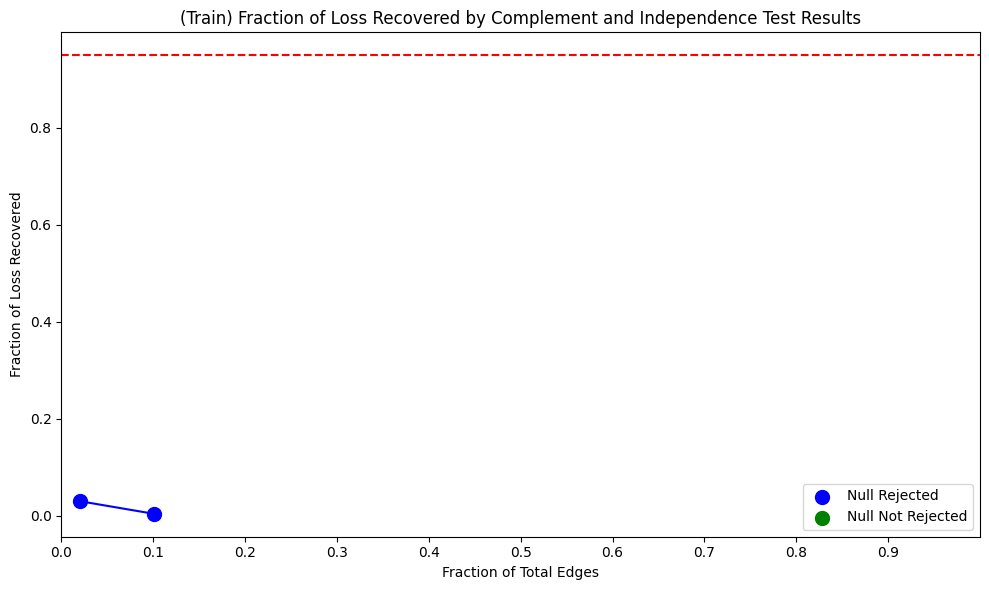

In [55]:
# plot % loss recovered and indep test results
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_c_train, 
    indep_results_train,
    title="(Train) Fraction of Loss Recovered by Complement and Independence Test Results",
    null_good=True,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_train.png")

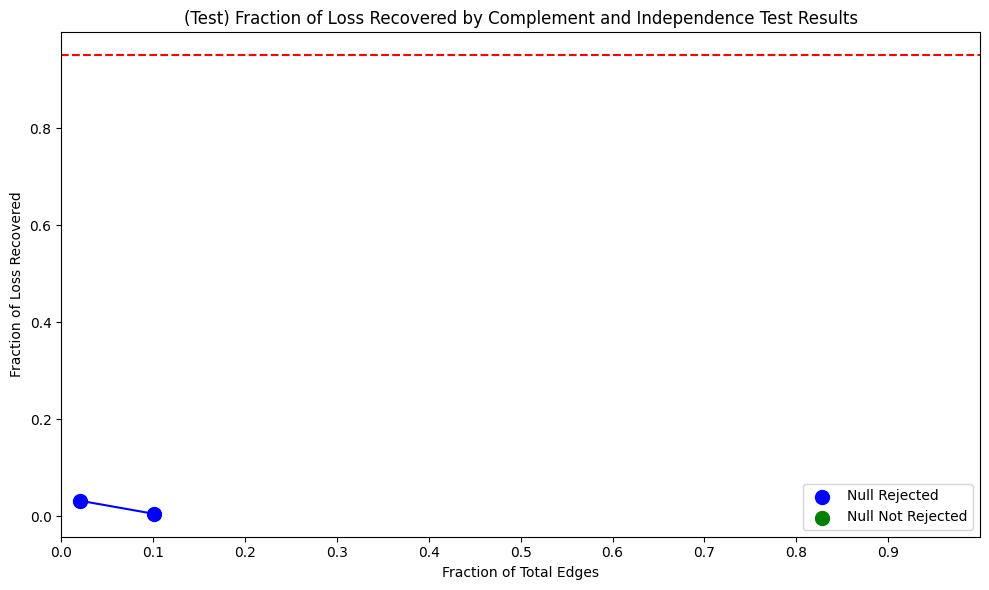

In [56]:
# plot % loss recovered and indep test results
fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
    faith_metric_results_c_test, 
    indep_results_test,
    title="(Test) Fraction of Loss Recovered by Complement and Independence Test Results",
    null_good=True,
    x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
)
fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_test.png")

In [ ]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_c_train_eval, 
        indep_results_train_eval,
        title="(Train) Fraction of Loss Recovered by Complement and Independence Test Results",
        null_good=True,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_train_eval.png")

In [ ]:
if conf.eval_answer_func is not None and conf.eval_answer_func != conf.answer_func:
    fig, ax = plot_frac_loss_recovered_and_equiv_test_results(
        faith_metric_results_c_test_eval, 
        indep_results_test_eval,
        title="(Test) Fraction of Loss Recovered by Complement and Independence Test Results",
        null_good=True,
        x_label="Edges" if not conf.prune_score_thresh else "Prune Scores"
    )
    fig.savefig(edge_dir / "frac_loss_recovered_and_indep_test_results_test_eval.png")

### Run Independence Test on True Edges

In [81]:
if TASK_TO_OUTPUT_ANSWER_FUNCS[task.key] == (conf.grad_func, conf.answer_func):
    indep_true_edge_result_test = next(iter(independence_tests(
        task.model, 
        task.test_loader, 
        task.model.circuit_prune_scores(task.true_edges), 
        ablation_type=conf.ablation_type,
        grad_func=conf.grad_func,
        answer_func=conf.answer_func,
        thresholds=[0.5], 
        model_out=model_out_test,
        alpha=conf.alpha,
        B=1000
    ).values()))
    save_json(result_to_json(indep_true_edge_result_test), out_answer_dir, f"indep_true_edge_result")